In [1]:
# load and concatenate waverider data
import numpy as np
import  json
import datetime as dt
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import os
import pandas as pd
import scipy.io
from IPython.display import display, HTML
#from scipy import interpolate, signal
#from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

In [2]:
#dirname = r'D:'
dirname = r"D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels"
fname = '221p1_historic.nc'
fname2 = '221p1_rt.nc'
fpath = os.path.join(dirname,fname)
print(fpath)
ds = xr.open_dataset(fpath,decode_times=True)
print(ds['waveTime'])
fpath2 = os.path.join(dirname,fname2)
print(fpath2)
ds2 = xr.open_dataset(fpath2,decode_times=True)
print(ds2['waveTime'])


D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels\221p1_historic.nc
<xarray.DataArray 'waveTime' (waveTime: 24145)>
array(['2016-05-20T15:07:45.000000000', '2016-05-20T15:37:45.000000000',
       '2016-05-20T16:07:45.000000000', ..., '2017-10-05T14:37:45.000000000',
       '2017-10-05T15:07:45.000000000', '2017-10-05T15:37:45.000000000'], dtype='datetime64[ns]')
Coordinates:
  * waveTime              (waveTime) datetime64[ns] 2016-05-20T15:07:45 ...
    metaStationLatitude   float32 ...
    metaStationLongitude  float32 ...
Attributes:
    long_name:      UTC sample start time
    standard_name:  time
    axis:           T
    bounds:         waveTimeBounds
    comment:        Spectral processing performed on 1600-second samples spec...
D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels\221p1_rt.nc
<xarray.DataArray 'waveTime' (waveTime: 18762)>
array(['2017-10-05T20:03:45.000000000', '2017-10-05T20:33:45.000000000',
       '2017-10-05T21:03:45.000000000', ..., '2018-11-09T20:

In [9]:
# Rich's suggestion (generates error)
#ds3 = xr.open_mfdataset([fpath, fpath2])

In [3]:
print(ds)
print(ds2)

<xarray.Dataset>
Dimensions:                     (dwrTime: 24146, gpsTime: 23709, metaBoundsCount: 2, sourceCount: 1, sstTime: 24146, waveFrequency: 64, waveTime: 24145)
Coordinates:
  * waveTime                    (waveTime) datetime64[ns] 2016-05-20T15:07:45 ...
  * waveFrequency               (waveFrequency) float32 0.025 0.03 0.035 ...
  * sstTime                     (sstTime) datetime64[ns] 2016-05-20T15:36:45 ...
  * gpsTime                     (gpsTime) datetime64[ns] 2016-05-20T15:30:15 ...
  * dwrTime                     (dwrTime) datetime64[ns] 2016-05-20T15:07:45 ...
    metaStationLatitude         float32 ...
    metaStationLongitude        float32 ...
Dimensions without coordinates: metaBoundsCount, sourceCount
Data variables:
    sourceFilename              (sourceCount) object ...
    waveTimeBounds              (waveTime, metaBoundsCount) datetime64[ns] ...
    waveFlagPrimary             (waveTime) float32 ...
    waveFlagSecondary           (waveTime) float32 ...
    

In [17]:
t =  np.concatenate( (ds['waveTime'].values, ds2['waveTime'].values) )
Hs = np.concatenate( (ds['waveHs'].values,   ds2['waveHs'].values )  )
Tp = np.concatenate( (ds['waveTp'].values,   ds2['waveTp'].values )  )
Ta = np.concatenate( (ds['waveTa'].values,   ds2['waveTa'].values )  )
Dp = np.concatenate( (ds['waveDp'].values,   ds2['waveDp'].values )  )

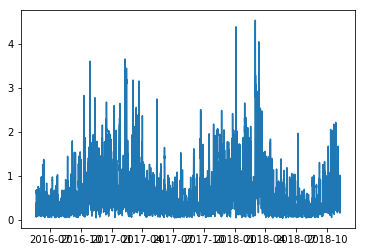

In [18]:
plt.plot(t,Hs)

In [48]:
wl_fpath = r"D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels"
fpath3 = os.path.join(wl_fpath,'Sandwidch_WL_surgeplustide_lag.mat')

wlevels = scipy.io.loadmat(fpath3)
wl = np.squeeze(np.array(wlevels["sand_total"]))
T = np.squeeze(np.array(wlevels["T"]))

print("Type and shape of T: ",type(T),print(np.shape(T)))

def matlab_datenum_to_datetime( dn ):
    """
    Convert matlab datenum to array of python datetime objects
    
    Input:
        dn - numpy array of matlab datenums   
    Returns:
        numpy array of datetime objects
    
    https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python/13965852#13965852
    """
    # loop through and make a list of datetime objects
    dtime = []
    for i in range(len(dn)):
      dtime.append( dt.datetime.fromordinal( int(dn[i])-366 ) + dt.timedelta(days=dn[i]%1) )
    # convert the list to an array
    return np.array(dtime)

dtime = matlab_datenum_to_datetime( T )

# Good info on datetime formatting:
# https://stackoverflow.com/questions/10624937/convert-datetime-object-to-a-string-of-date-only-in-python
print("First time: ",'{:%m/%d/%Y %H:%M:%S}'.format(dtime[0]))
print("Last time : ",'{:%m/%d/%Y %H:%M:%S}'.format(dtime[-1]))

(113857,)
Type and shape of T:  <class 'numpy.ndarray'> None
First time:  01/01/2015 00:00:00
Last time :  04/01/2018 00:00:00


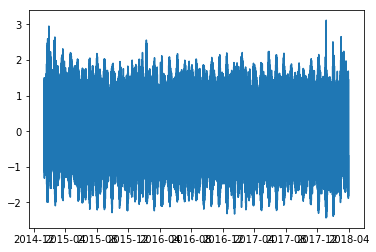

In [49]:
plt.plot(dtime,wl)